[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nlebovits/datos-escala-humana/blob/main/es/python-geoespacial/unidad_1b_soluciones.ipynb)

## Fundamentos de GIS en Python

¡Bienvenidos a 'Datos abiertos para ciudades resilientes'! En esta primera clase, vamos a explorar los fundamentos del GIS en Python: datos vectoriales y raster, sistemas de referencia de coordenadas, importación de datos, visualizaciones básicas, operaciones y análisis básicos y cómo aprender más. Trabajamos con datos reales: datos de departamentos y cuencas de la Provincia de Buenos Aires, y datos de elevación y cobertura del suelo de Copernicus y MapBiomas, respectivamente.

*Para completar el taller, ejecutá las celdas en secuencia, asegurándote de completar los fragmentos de código faltantes marcados con comentarios TODO y las instrucciones correspondientes.*

## Sección 1: Datos Vectoriales

### 1.1: Módulos y constantes
Para comenzar tenemos que importar los módulos que vamos a usar. Cada módulo corresponde a una funcionalidad que usamos en este análisis. Por ejemplo, `geopandas` para la manipulación de datos vectoriales en Python.

In [1]:
import matplotlib.pyplot as plt
from io import StringIO
import geopandas as gpd
import requests
import os
import numpy as np
from io import BytesIO
from owslib.wfs import WebFeatureService
import rioxarray
from rasterstats import zonal_stats
import matplotlib.colors as mcolors
import pystac_client
from odc.stac import load

Luego definimos nuestros CRS (sistemas de referencia de coordenadas). Usamos dos: EPSG 5348 (Posgar 7 para La Plata), que se mide en metros para los análisis específicos, y EPSG 4326, el sistema estándar de longitud y latitud para las consultas de los API.

In [2]:
USE_CRS = "EPSG:5348"  # POSGAR 2007 / Argentina 4
WGS84_CRS = "EPSG:4326"  # para los API

### 1.2: Importar datos de partidos

Importamos los datos desde un WFS (Web Feature Service), un servidor donde se encuentran los datos de ARBA en formato vectorial. Conectamos mediante `owslib` e importamos los datos de todos los departamentos en la provincia de Buenos Aires.

Los leemos mediante `geopandas` (GPD) y los convertimos a la proyección EPSG 5348.

In [3]:
partidos_path = "data/pba_partidos.geojson"

# Cargar partidos desde el servicio WFS de ARBA GeoServer
if os.path.exists(partidos_path):
    partidos = gpd.read_file(partidos_path)
else:
    # Conectar al servicio WFS (Web Feature Service)
    wfs_url = "https://geo.arba.gov.ar/geoserver/idera/wfs"
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    # Solicitar la capa de Departamento (partidos)
    response = wfs.getfeature(
        typename="idera:Departamento",
        srsname="EPSG:5347",  # CRS original
    )

    # Convertir respuesta WFS a GeoDataFrame
    partidos = gpd.read_file(BytesIO(response.read()))

    # Guardar en caché para uso futuro
    partidos.to_file(partidos_path, driver="GeoJSON")

# Reproyectar al CRS de trabajo
partidos = partidos.to_crs(USE_CRS)

Podemos ver las primeras 5 observaciones en `partidos` mediante `.head()`...

In [4]:
partidos.head()

,gml_id,cca,cde,fna,gna,nam,sag,ara3,arl,geometry
0,Departamento.546,131,06760,Partido de San Miguel,Partido,San Miguel,ARBA,82.06,82.80,"MULTIPOLYGON (((6343805.512 6177880.325, 63420..."
1,Departamento.433,004,06035,Partido de Avellaneda,Partido,Avellaneda,ARBA,57.27,52.48,"MULTIPOLYGON (((6374002.895 6164551.5, 6374068..."
2,Departamento.434,090,06686,Partido de Rojas,Partido,Rojas,ARBA,2060.72,1978.87,"MULTIPOLYGON (((6128472.001 6214278.169, 61285..."
3,Departamento.436,058,06455,Partido de Las Flores,Partido,Las Flores,ARBA,3341.36,3340.27,"MULTIPOLYGON (((6292198.682 5974257.073, 62916..."
4,Departamento.485,031,06266,Partido de Exaltación de la Cruz,Partido,Exaltación de la Cruz,ARBA,636.36,634.17,"MULTIPOLYGON (((6286757.47 6218024.36, 6286781..."


...y mapearlos de manera básica con `.plot()`. Van a ver que los datos incluyen todos los partidos de la provincia de Buenos Aires, mucho más de lo que necesitamos.

<Axes: >

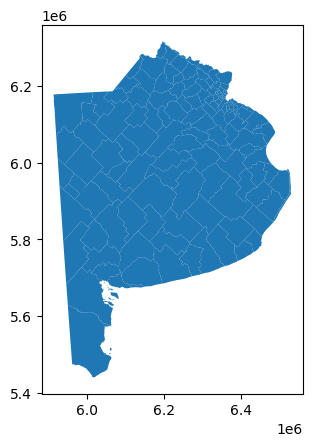

In [5]:
partidos.plot()

Los datos de `partidos` tienen varios atributos: código del departamento, nombre del departamento y geometría. Para sacar solo los datos del Partido de La Plata, podemos filtrarlos por la observación donde la columna "fna" corresponde a "Partido de La Plata".

In [6]:
la_plata = partidos[partidos["fna"] == "Partido de La Plata"]

In [7]:
la_plata.head()

,gml_id,cca,cde,fna,gna,nam,sag,ara3,arl,geometry
18,Departamento.496,055,06441,Partido de La Plata,Partido,La Plata,ARBA,892.63,942.23,"MULTIPOLYGON (((6395811.772 6128078.545, 63970..."



Sin embargo, al mapearlo vemos que incluye no solo la zona urbana sino también una isla que es técnicamente parte del partido.

<Axes: >

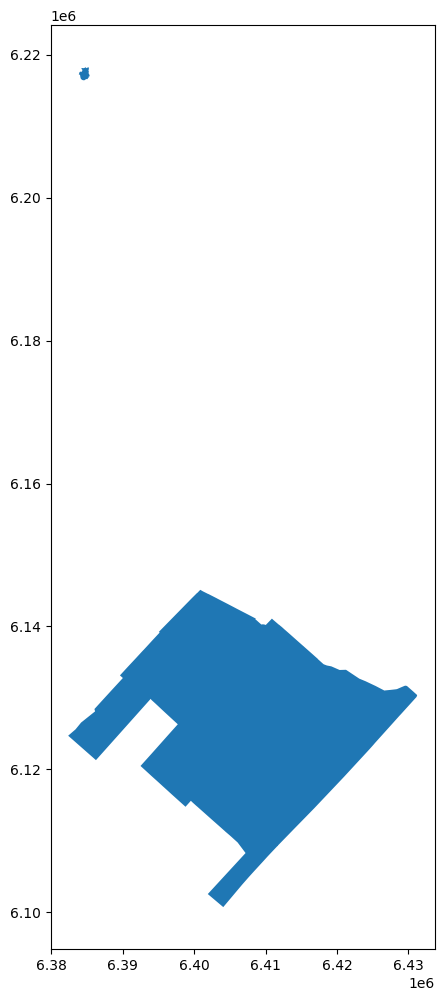

In [8]:
la_plata.plot(figsize=(12, 12))  # asi adjustamos el tamaño de la figura

Al examinar el tipo de geometría, vemos que tenemos un multipolígono. La geometría puede ser un punto, una línea, un polígono o un multipolígono (las formas más comunes).

In [9]:
print(la_plata.geometry.iloc[0].geom_type)

MultiPolygon


Queremos eliminar la isla porque no corresponde a nuestro análisis. Extraemos la geometría más grande de las dos. Esto es específico de nuestro análisis—no necesitan hacerlo normalmente.

In [10]:
# Obtener la geometría principal y mantener solo el polígono más grande
# Esto elimina pequeñas islas que aparecen en los datos
la_plata = la_plata.copy()
main_geom = la_plata.geometry.iloc[0]
la_plata.loc[la_plata.index[0], "geometry"] = max(main_geom.geoms, key=lambda p: p.area)

Al chequear la geometría nuevamente, vemos que ahora es un polígono simple y aparece únicamente el partido de La Plata sin la isla.

In [11]:
print(la_plata.geometry.iloc[0].geom_type)

Polygon


<Axes: >

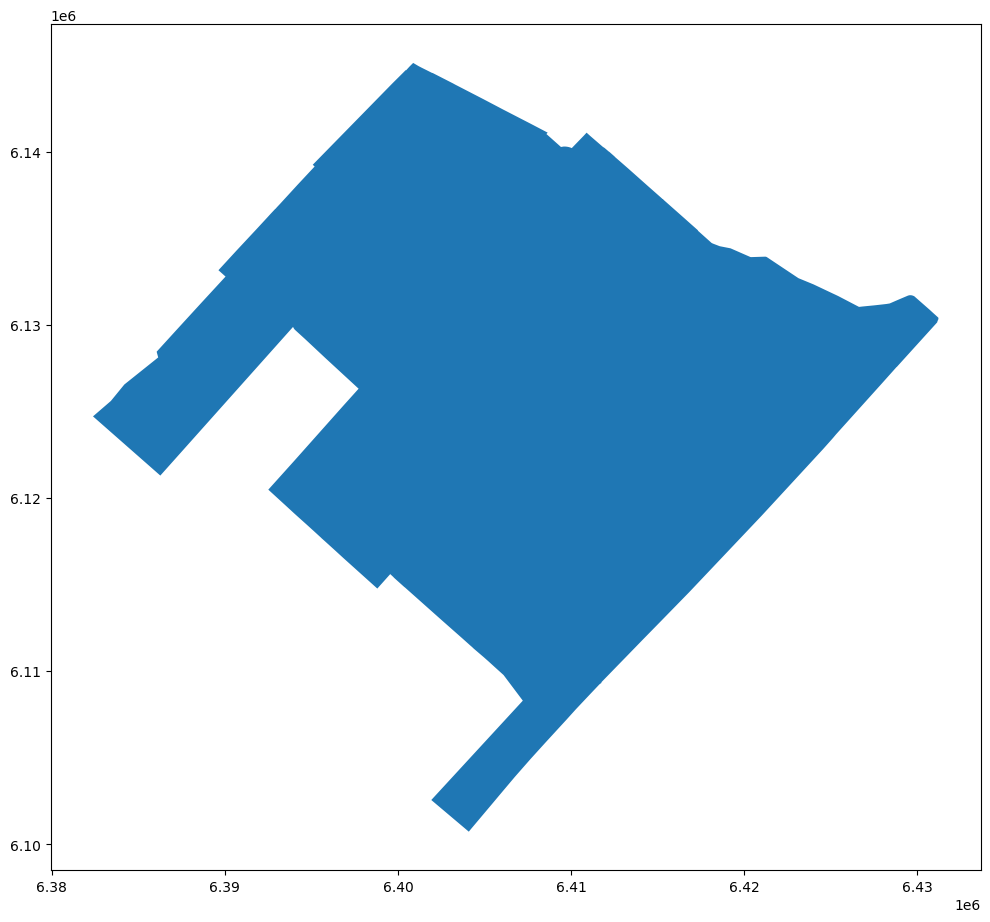

In [12]:
la_plata.plot(figsize=(12, 12))

### 1.3: Datos de cuencas

Importamos las cuencas de la Provincia de Buenos Aires desde un servidor de ArcGIS que contiene los datos más recientes (2023).

In [14]:
cuencas_path = "data/cuencas_buenos_aires.geojson"

# Cargar cuencas de Buenos Aires desde caché o ArcGIS REST API
if os.path.exists(cuencas_path):
    cuencas = gpd.read_file(cuencas_path)
else:
    # Parámetros para consultar todas las features en formato GeoJSON
    params = {"where": "1=1", "outFields": "*", "f": "geojson"}

    # Consultar el servicio de cuencas de Buenos Aires (2023)
    cuencas_response = requests.get(
        "https://services1.arcgis.com/atxllciEI8CHWvwW/ArcGIS/rest/services/Cuencas_BuenosAires_2023/FeatureServer/0/query",
        params=params,
    )

    # Guardar respuesta en caché para uso futuro
    with open(cuencas_path, "w", encoding="utf-8") as f:
        f.write(cuencas_response.text)

    # Cargar los datos desde la respuesta
    cuencas = gpd.read_file(StringIO(cuencas_response.text))
    cuencas.to_file(cuencas_path, driver="GeoJSON")

In [15]:
# reproyectar las cuencas a USE_CRS
cuencas = cuencas.to_crs(USE_CRS)

Al mapearlas, corresponden a la provincia completa.

<Axes: >

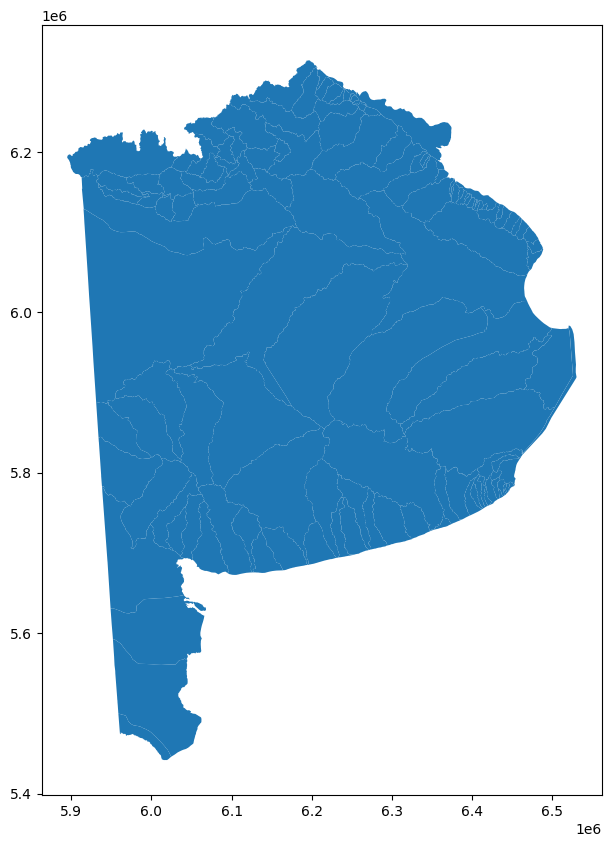

In [16]:
cuencas.plot(figsize=(10, 10))

In [17]:
cuencas.head()

,FID,Shape_Leng,Cuenca,Sistema,Subcuenca,RegiónHí,Superficie,FuenteEdic,Observacio,Jurisdicci,FechaEdici,Porcentaje,Shape__Area,Shape__Length,geometry
0,1,64739.954408,Cuenca Río Arrecifes,REGION NORESTE,,,"7681,344444792",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.000000,0.007466,0.533819,"MULTIPOLYGON (((6268131.732 6256973.822, 62681..."
1,2,262235.241263,Cuenca Río Arrecifes,REGION NORESTE,,,"82870,3624883858",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.000000,0.080610,2.168381,"MULTIPOLYGON (((6213496.653 6264169.857, 62134..."
2,3,594892.298067,Cuenca Río Arrecifes,REGION NORESTE,,,"238690,056943605",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,85.608089,0.232548,4.902046,"MULTIPOLYGON (((6156795.443 6232763.779, 61568..."
3,4,331224.014317,Cuenca Río Arrecifes,REGION NORESTE,,,"194549,510611065",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.000000,0.189737,2.716846,"MULTIPOLYGON (((6264237.019 6251011.577, 62642..."
4,5,148503.122930,Cuenca Río Arrecifes,REGION NORESTE,,,"33652,5242803464",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.000000,0.032931,1.218285,"POLYGON ((6158735.927 6188394.083, 6158735.816..."


¿Cómo filtramos estas cuencas para incluir solo la zona de La Plata? Podríamos filtrar por atributos, pero tendríamos que saber el nombre exacto de cada cuenca.

Otra opción es realizar una intersección espacial: filtramos solamente las geometrías que intersectan con la zona de La Plata.

Existen varias maneras de hacer intersecciones geoespaciales usando spatial predicates (predicados espaciales): las que tocan la zona, las que están completamente dentro, las que están fuera, etc. Pueden consultar la documentación para más información.

Aquí analizamos cada cuenca que está dentro o toca el partido de La Plata, y creamos un mapa con las cuencas superpuestas.

In [18]:
# Filtrar cuencas que intersectan con La Plata (preserva las geometrías completas de las cuencas)
cuencas = cuencas[cuencas.intersects(la_plata.geometry.union_all())]

<Axes: >

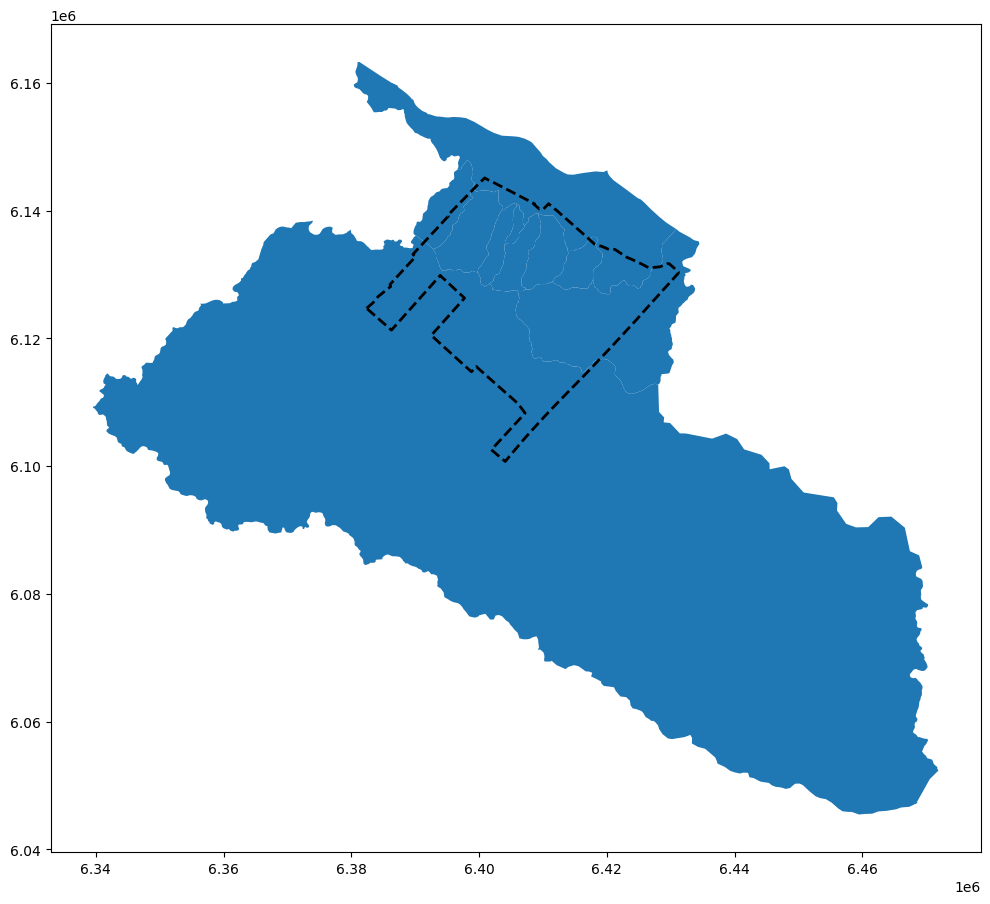

In [19]:
ax = cuencas.plot(figsize=(12, 12))
la_plata.plot(ax=ax, edgecolor="black", linestyle="--", linewidth=2, facecolor="none")

### 1.4: Cuestiones analíticas

¿Cuáles son las cuencas que intersectan con La Plata y cuántas hay?

In [20]:
cuencas.shape

(10, 15)

In [21]:
cuencas

,FID,Shape_Leng,Cuenca,Sistema,Subcuenca,RegiónHí,Superficie,FuenteEdic,Observacio,Jurisdicci,FechaEdici,Porcentaje,Shape__Area,Shape__Length,geometry
32,33,19236.244516,Cuenca Arroyo Rodriguez-Don Carlos,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"887,068225196789",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.000871,0.150773,"POLYGON ((6407121.684 6137599.948, 6407055.463..."
34,35,39820.331396,Cuenca Arroyo del Gato,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"5273,32277290421",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.005181,0.317383,"POLYGON ((6413898.815 6133667.85, 6413925.461 ..."
35,36,43000.322580,Cuenca Arroyo del Gato,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"4271,19872965366",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.004197,0.345024,"POLYGON ((6409320.586 6139510.939, 6409310.476..."
36,37,38674.846450,Cuenca Arroyo Rodriguez-Don Carlos,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"3286,50875162584",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.003229,0.302683,"POLYGON ((6405838.386 6140621.104, 6405831.584..."
38,39,49909.960338,Cuenca Arroyo Martín-Carnaval,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"8009,03092658122",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.007868,0.403494,"POLYGON ((6399462.032 6143111.659, 6399475.211..."
53,54,46705.062925,Cuenca Arroyo Pereyra,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"6058,43053467506",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.005949,0.375855,"POLYGON ((6399462.032 6143111.659, 6399389.256..."
54,55,133540.695640,Cuenca Arroyo El Pescado,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"35801,0766550378",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.035204,1.093985,"POLYGON ((6434443.863 6135013.288, 6434453.92 ..."
72,73,196378.882637,Area de Bañados,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"44765,3597785269",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.043929,1.624145,"POLYGON ((6430875.128 6137122.557, 6430140.185..."
83,84,539510.943789,Cuenca Río Samborombón,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"564984,698530456",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.557467,4.467349,"POLYGON ((6379880.019 6137071.96, 6379888.632 ..."
129,130,32606.204061,Cuenca A° Maldonado,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,"3580,67937557204",COHIFE - Comisión Mapa de cuencas,,Buenos Aires,1696906800000,100.0,0.003518,0.266847,"POLYGON ((6417851.324 6129322.069, 6417844.749..."


Para saber el área en metros cuadrados de cada zona, calculamos el área y ordenamos los resultados de mayor a menor.

In [22]:
# agregar una columna con el área en metros cuadrados
cuencas["area_m"] = cuencas.geometry.area

# ordenar las observaciones por área de mayor a menor
cuencas = cuencas.sort_values("area_m", ascending=False)

cuencas[["Cuenca", "area_m"]]

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Cuenca,area_m
83,Cuenca Río Samborombón,5.626548e+09
72,Area de Bañados,4.457880e+08
54,Cuenca Arroyo El Pescado,3.564201e+08
38,Cuenca Arroyo Martín-Carnaval,7.978092e+07
53,Cuenca Arroyo Pereyra,6.035630e+07
34,Cuenca Arroyo del Gato,5.251302e+07
35,Cuenca Arroyo del Gato,4.253879e+07
129,Cuenca A° Maldonado,3.565223e+07
36,Cuenca Arroyo Rodriguez-Don Carlos,3.273456e+07
32,Cuenca Arroyo Rodriguez-Don Carlos,8.834710e+06


## Sección 2: Datos raster

### 2.1 Modelo digital de superficie

Trabajamos con datos de DSM (Modelo Digital de Superficie) que provienen de Copernicus (Agencia Espacial Europea) [almacenados en Open Land Map](https://radiantearth.github.io/stac-browser/#/external/s3.eu-central-1.wasabisys.com/stac/openlandmap/dsm_glo30/collection.json).


Usamos un Cloud Optimized GeoTIFF (GeoTIFF Optimizado para la Nube), un formato diseñado para facilitar el trabajo en la nube, junto con el módulo `rioxarray` para importar solamente los datos necesarios de manera eficaz. En lugar de importar todos los datos globales (varios terabytes), importamos únicamente nuestra área de interés mediante lazy loading (carga perezosa). Esto significa que no descargamos los datos hasta haberlos filtrado, usando así solamente la memoria y poder computacional esencial.

In [ ]:
# 1. Conectar al catálogo de Element84 Earth Search, que tiene el DEM de Copernicus
# Planetary Computer es una plataforma que provee acceso gratuito a datasets globales

# usar consultas "unsigned" (sin login)
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"

catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

# 2. Reproyectar las cuencas al CRS del raster (EPSG:4326)
# Necesitamos esto para buscar los datos correctos en el catálogo
cuencas_4326 = cuencas.to_crs("EPSG:4326")

# 3. Obtener el bounding box (caja delimitadora) de nuestras cuencas
# bbox define el área geográfica de interés: [min_x, min_y, max_x, max_y]
bbox = cuencas_4326.total_bounds

# 4. Buscar el Modelo Digital de Superficie (DSM) de Copernicus para nuestra área
# cop-dem-glo-30 es el mismo dataset global de elevación que usábamos de OpenLandMap
search = catalog.search(
    collections=["cop-dem-glo-30"],  # Copernicus DEM Global 30m
    bbox=bbox,  # Limitamos la búsqueda a nuestro área de interés
)

# Obtener los items (archivos) que cubren nuestra área
items = list(search.items())

# 5. Cargar el DSM usando chunks para procesamiento eficiente en memoria
# odc.stac.load descarga y ensambla automáticamente los tiles necesarios
dsm = load(
    items,
    bbox=bbox,
    chunks={"x": 1024, "y": 1024},  # Procesamiento por bloques para eficiencia
)

# 6. Extraer la banda de elevación y convertir a DataArray para usar con rioxarray
# El resultado de load() es un Dataset; necesitamos el DataArray de elevación
dsm = dsm["data"].squeeze()  # squeeze() elimina dimensiones extra

# 7. Recortar el raster a las geometrías exactas de las cuencas
dsm_clipped = dsm.rio.clip(cuencas_4326.geometry)

# 8. Reproyectar el área recortada al CRS de trabajo (POSGAR 7)
# Esto es más eficiente porque reproyectamos solo el área de interés
dsm_clipped_reproj = dsm_clipped.rio.reproject(dst_crs=USE_CRS)

Los datos de elevación son un ejemplo de datos continuos, lo que significa que los valores pueden tomar cualquier número dentro de un rango (incluyendo decimales). Estos valores se almacenan como floats (números de punto flotante) en vez de enteros, permitiendo representar mediciones precisas como 15.7 metros o 23.42 metros de elevación.

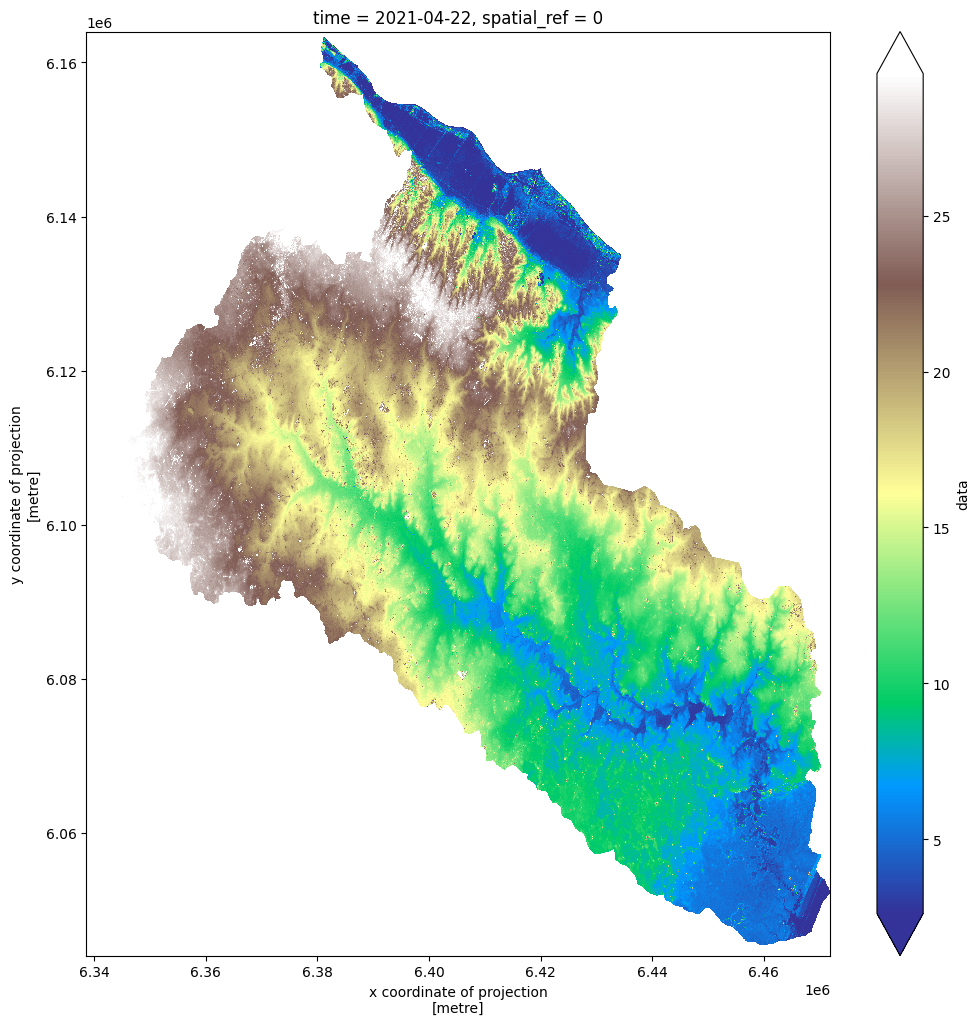

In [ ]:
dsm_clipped_reproj.plot(robust=True, cmap="terrain", figsize=(12, 12))

Para conocer la distribución de valores (promedio, máximo, mínimo, mediano), podemos crear un histograma.

In [41]:
# TODO: imprimí los valores minimo, maximo, mediano y promedio de dsm_clipped_reproj
print(
    f"Min: {dsm_clipped_reproj.min().values}, Max: {dsm_clipped_reproj.max().values}, Median: {dsm_clipped_reproj.median().values}, Mean: {dsm_clipped_reproj.mean().values}"
)

Min: -4.3202924728393555, Max: 56.864131927490234, Median: 14.23167085647583, Mean: 14.652371406555176


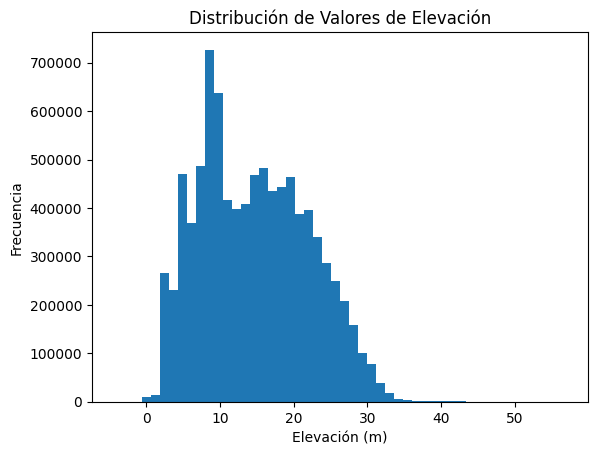

In [42]:
# TODO: Crea un histograma de los valores de elevación usando dsm_clipped_reproj.plot.hist() con 50 bins
# Agrega etiquetas para los ejes x ('Elevación (m)') y y ('Frecuencia'), y un título descriptivo
dsm_clipped_reproj.plot.hist(bins=50)
plt.xlabel("Elevación (m)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Valores de Elevación")
plt.show()

Para saber cómo varían los valores en las distintas cuencas, usamos estadística zonal, calculando el mínimo, máximo, mediano y promedio por cuenca. Podemos crear un gráfico para visualizar, por ejemplo, cuál cuenca tiene la elevación promedio más baja o la mediana más alta.

In [44]:
# Crear una copia independiente de cuencas para evitar modificar el original
cuencas = cuencas.copy()

# Extraer estadísticas de elevación (min, mean, median, max) para cada polígono de cuenca
stats = zonal_stats(
    cuencas,  # Polígonos de las cuencas
    dsm_clipped_reproj.values,  # Valores del raster (sin [0])
    affine=dsm_clipped_reproj.rio.transform(),  # Transformación geoespacial del raster
    stats=["min", "mean", "median", "max"],  # Estadísticas a calcular
    nodata=np.nan,  # Valor a ignorar (NoData)
)

# Agregar las estadísticas calculadas como nuevas columnas en el GeoDataFrame
cuencas["dsm_min"] = [s["min"] for s in stats]
cuencas["dsm_mean"] = [s["mean"] for s in stats]
cuencas["dsm_median"] = [s["median"] for s in stats]
cuencas["dsm_max"] = [s["max"] for s in stats]

# Mostrar columnas seleccionadas con información de cuencas y estadísticas de elevación
cuencas[
    [
        "Cuenca",
        "Sistema",
        "Subcuenca",
        "RegiónHí",
        "dsm_min",
        "dsm_mean",
        "dsm_median",
        "dsm_max",
    ]
]

,Cuenca,Sistema,Subcuenca,RegiónHí,dsm_min,dsm_mean,dsm_median,dsm_max
83,Cuenca Río Samborombón,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,0.000000,15.002222,14.440168,56.864132
72,Area de Bañados,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,-3.647730,5.941934,3.415808,37.641655
54,Cuenca Arroyo El Pescado,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,0.000000,14.736844,15.591372,47.508526
38,Cuenca Arroyo Martín-Carnaval,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,1.560721,21.881409,22.887115,52.470333
53,Cuenca Arroyo Pereyra,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,2.410506,22.778730,23.634939,44.905403
34,Cuenca Arroyo del Gato,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,2.931544,19.543804,20.404808,52.557846
35,Cuenca Arroyo del Gato,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,-4.320292,19.691474,20.535738,41.652542
129,Cuenca A° Maldonado,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,1.640185,17.657394,18.716934,36.001190
36,Cuenca Arroyo Rodriguez-Don Carlos,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,3.994384,21.402138,21.700775,39.326633
32,Cuenca Arroyo Rodriguez-Don Carlos,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,-1.119239,16.013293,16.204729,32.383595


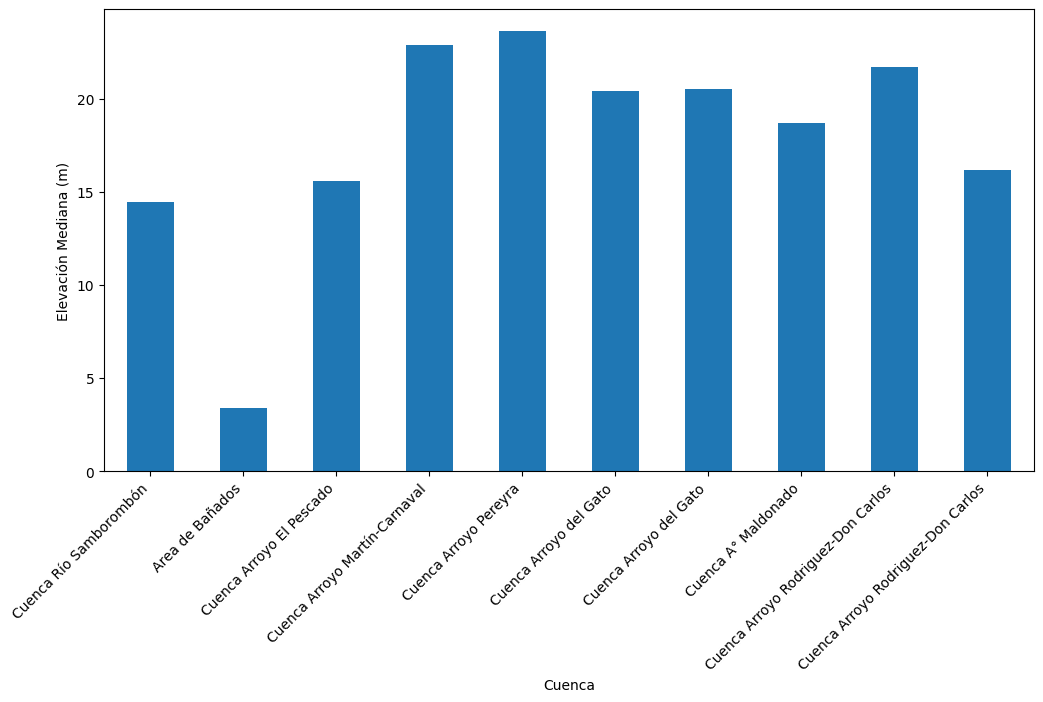

In [45]:
# TODO: Crea un gráfico de barras de la elevación mediana por cuenca:
# - Usa cuencas.plot(kind='bar', x='Cuenca', y='dsm_median', figsize=(12, 6), legend=False)
# - Agrega etiquetas: plt.xlabel('Cuenca') y plt.ylabel('Elevación Mediana (m)')
# - Rota las etiquetas del eje x: plt.xticks(rotation=45, ha='right')
cuencas.plot(kind="bar", x="Cuenca", y="dsm_median", figsize=(12, 6), legend=False)
plt.xlabel("Cuenca")
plt.ylabel("Elevación Mediana (m)")
plt.xticks(rotation=45, ha="right")
plt.show()

### 2.2: Cobertura del suelo

Los datos anteriores eran continuos (float, números con decimales). Los rasters también pueden tener datos categóricos, codificados con números enteros que representan categorías.

Importamos datos de cobertura del suelo del proyecto MapBiomas, que tiene información de Argentina desde 1998 hasta 2022. Son los datos más confiables a 30 metros de resolución disponibles actualmente.

In [ ]:
# TODO: Cargar y procesar el raster de cobertura del suelo MapBiomas 2022
# Sigue el MISMO PATRÓN que usamos para el DSM arriba

# 1. Define la URL del raster como suelo_2022_ruta
suelo_2022_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2022.tif"

# 2. Abre el raster con rioxarray y chunks de 1024x1024
suelo_2022 = rioxarray.open_rasterio(
    suelo_2022_ruta,
    chunks={"x": 1024, "y": 1024},
)

# 3. Recorta PRIMERO en el CRS nativo del raster (EPSG:4326) y guarda el resultado en suelo_2022_clipped
suelo_2022_clipped = suelo_2022.rio.clip(
    cuencas_4326.geometry.values,
    from_disk=True,
)

# 4. Reproyecta el área recortada al USE_CRS de trabajo (POSGAR 7) y guarda el resultado final en suelo_2022
suelo_2022 = suelo_2022_clipped.rio.reproject(dst_crs=USE_CRS)

In [61]:
# Enmascarar valores NoData (255) para excluirlos de la visualización
# MapBiomas usa 255 como NoData además del NoData estándar
suelo_2022_masked = suelo_2022.where(
    (suelo_2022 != suelo_2022.rio.nodata) & (suelo_2022 != 255)
)

Al plotearlos inicialmente, no es evidente a qué corresponde cada valor.

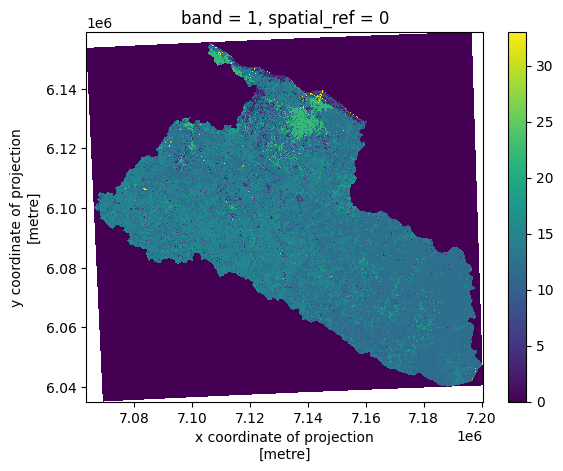

In [62]:
# TODO: ploteá suelo_2022_masked con .plot()
suelo_2022_masked.plot()

Les proporciono un diccionario del proyecto MapBiomas que traduce entre valores numéricos, categorías y colores. Con esto podemos mapear los datos correctamente.

Ahora vemos un mapa coherente de la cobertura del suelo: zonas urbanizadas, agrícolas, naturales y cuerpos de agua. Discutan con un compañero si los datos parecen lógicos y si pueden identificar el casco urbano, City Bell, Berisso y Ensenada.

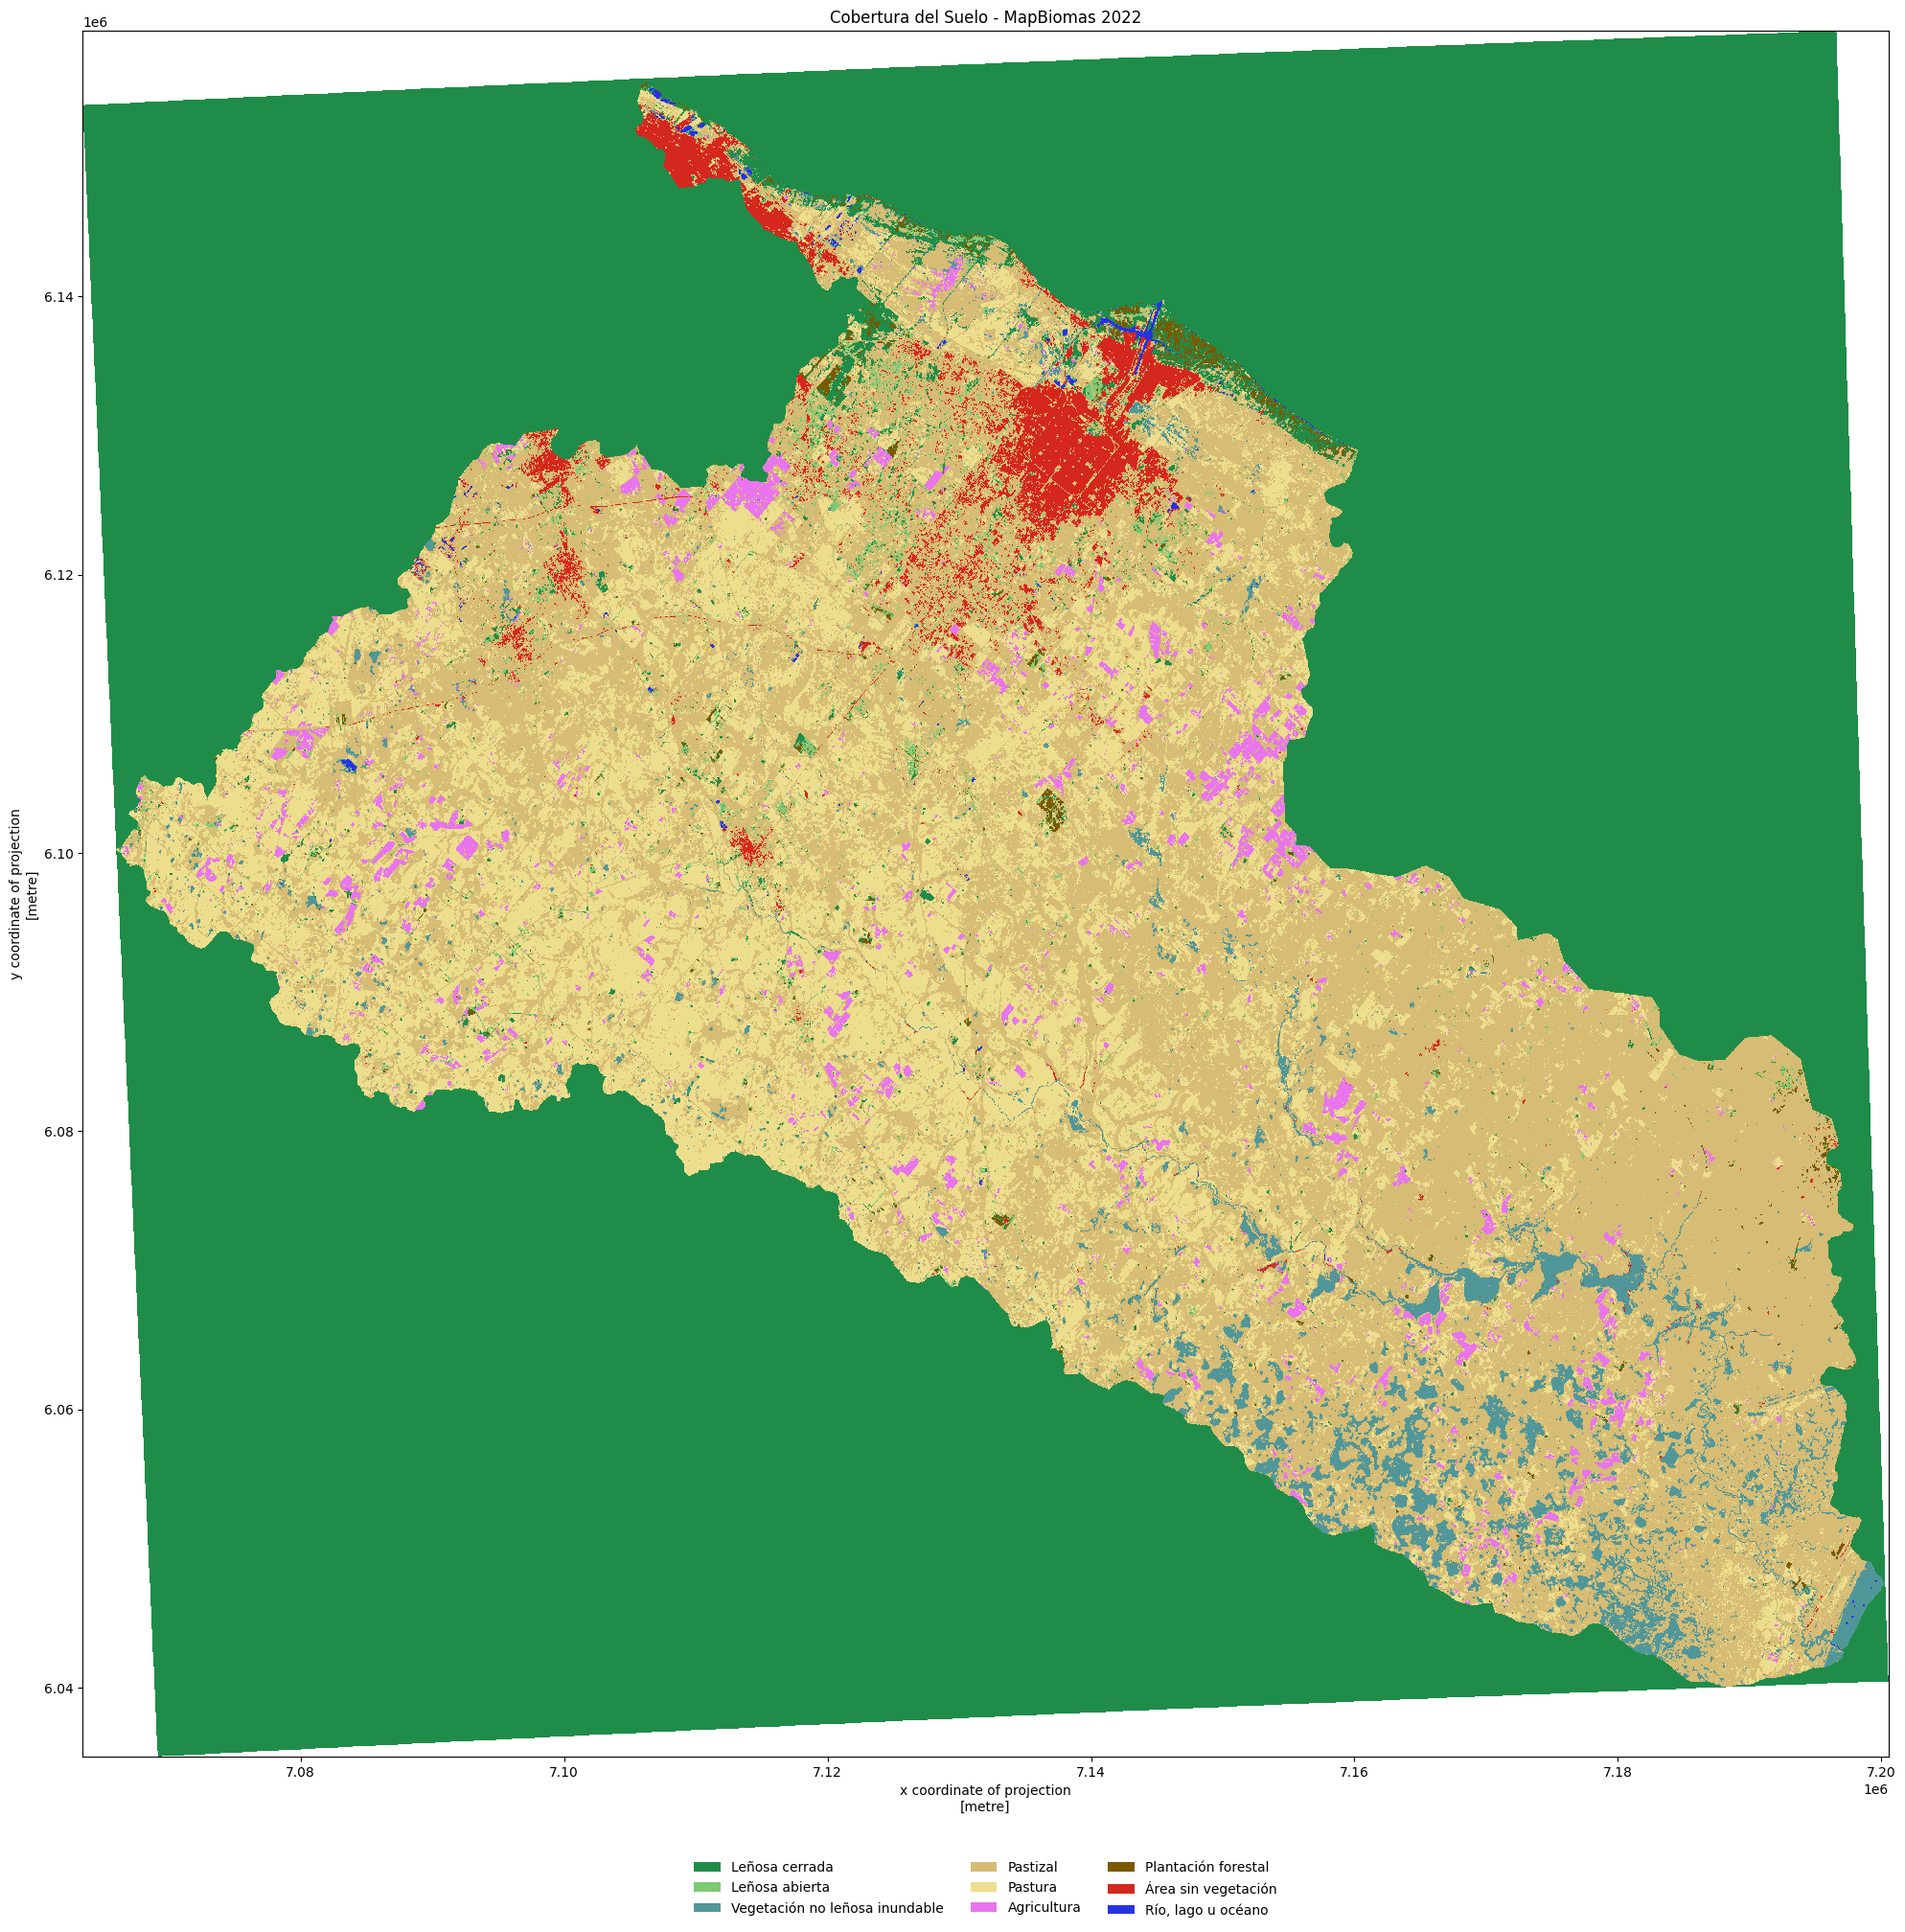

In [63]:
# Definir categorías de cobertura del suelo con sus IDs y colores MapBiomas
categorias = {
    "Leñosa cerrada": {"ids": [3], "color": "#1f8d49"},
    "Leñosa abierta": {"ids": [4], "color": "#7dc975"},
    "Leñosa dispersa": {"ids": [45], "color": "#807a40"},
    "Leñosa inundable": {"ids": [6], "color": "#026975"},
    "Vegetación no leñosa inundable": {"ids": [11], "color": "#519799"},
    "Pastizal": {"ids": [12], "color": "#d6bc74"},
    "Estepa": {"ids": [63], "color": "#ebf8b5"},
    "Pastura": {"ids": [15], "color": "#edde8e"},
    "Agricultura": {"ids": [18], "color": "#e974ed"},
    "Plantación forestal": {"ids": [9], "color": "#7a5900"},
    "Cultivo arbustivo": {"ids": [36], "color": "#d082de"},
    "Mosaico agropecuario": {"ids": [21], "color": "#ffefc3"},
    "Área sin vegetación": {"ids": [22], "color": "#d4271e"},
    "Río, lago u océano": {"ids": [33], "color": "#2532e4"},
    "Hielo y nieve en superficie": {"ids": [34], "color": "#93dfe6"},
    "No observado": {"ids": [27], "color": "#ffffff"},
}

# Obtener los IDs únicos presentes en los datos
valores_unicos = np.unique(
    suelo_2022_masked.values[~np.isnan(suelo_2022_masked.values)]
).astype(int)
ids_presentes = set(valores_unicos)

# Filtrar solo las categorías que aparecen en nuestros datos
categorias_presentes = {
    nombre: info
    for nombre, info in categorias.items()
    if any(id in ids_presentes for id in info["ids"])
}

# Crear mapa de colores: asignar cada ID de píxel a su color correspondiente
colores_por_id = {}
for info in categorias.values():
    for id_pixel in info["ids"]:
        colores_por_id[id_pixel] = info["color"]

# Construir el colormap para matplotlib
ids_ordenados = sorted(colores_por_id.keys())
cmap = mcolors.ListedColormap([colores_por_id[i] for i in ids_ordenados])
norm = mcolors.BoundaryNorm(ids_ordenados, cmap.N)

# Visualizar el raster de cobertura del suelo
fig, ax = plt.subplots(figsize=(20, 20))

suelo_2022_masked.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Crear leyenda solo con las categorías presentes
leyenda = [
    plt.Rectangle((0, 0), 1, 1, facecolor=info["color"], label=nombre)
    for nombre, info in categorias_presentes.items()
]

ax.legend(
    handles=leyenda,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
)

plt.title("Cobertura del Suelo - MapBiomas 2022")
plt.tight_layout()
plt.show()

Podemos analizar la distribución calculando el porcentaje de cada clase de cobertura.

In [64]:
# Analizar la distribución de cobertura del suelo en toda el área de estudio

# Paso 1: Extraer valores del raster y eliminar NoData
valores = suelo_2022_masked.values.flatten()
valores = valores[~np.isnan(valores)]
print(f"Total de píxeles válidos: {len(valores):,}")
print(f"Rango de valores: {valores.min():.0f} - {valores.max():.0f}")

Total de píxeles válidos: 22,224,274
Rango de valores: 0 - 33


In [65]:
# Paso 2: Contar píxeles de cada ID único
ids_unicos, conteos = np.unique(valores, return_counts=True)
print(f"\nIDs únicos encontrados: {ids_unicos}")
print("Conteo por ID:")
for id_pixel, conteo in zip(ids_unicos, conteos):
    print(f"  ID {id_pixel}: {conteo:,} píxeles")


IDs únicos encontrados: [ 0.  3.  4.  9. 11. 12. 15. 18. 22. 33.]
Conteo por ID:
  ID 0.0: 12,667,423 píxeles
  ID 3.0: 132,117 píxeles
  ID 4.0: 123,848 píxeles
  ID 9.0: 57,940 píxeles
  ID 11.0: 408,544 píxeles
  ID 12.0: 5,256,181 píxeles
  ID 15.0: 3,017,618 píxeles
  ID 18.0: 271,637 píxeles
  ID 22.0: 274,195 píxeles
  ID 33.0: 14,771 píxeles


In [66]:
# Paso 3: Agrupar IDs por categoría de cobertura
conteos_por_categoria = {}
for nombre, info in categorias.items():
    # Sumar píxeles de todos los IDs que pertenecen a esta categoría
    total = sum(
        conteos[ids_unicos == id_pixel][0] if id_pixel in ids_unicos else 0
        for id_pixel in info["ids"]
    )
    if total > 0:
        conteos_por_categoria[nombre] = {"conteo": total, "color": info["color"]}

print(f"\nCategorías encontradas: {len(conteos_por_categoria)}")
for nombre, datos in conteos_por_categoria.items():
    print(f"  {nombre}: {datos['conteo']:,} píxeles")


Categorías encontradas: 9
  Leñosa cerrada: 132,117 píxeles
  Leñosa abierta: 123,848 píxeles
  Vegetación no leñosa inundable: 408,544 píxeles
  Pastizal: 5,256,181 píxeles
  Pastura: 3,017,618 píxeles
  Agricultura: 271,637 píxeles
  Plantación forestal: 57,940 píxeles
  Área sin vegetación: 274,195 píxeles
  Río, lago u océano: 14,771 píxeles


In [67]:
# Paso 4: Calcular porcentajes
total_pixeles = sum(cat["conteo"] for cat in conteos_por_categoria.values())
for nombre in conteos_por_categoria:
    porcentaje = (conteos_por_categoria[nombre]["conteo"] / total_pixeles) * 100
    conteos_por_categoria[nombre]["porcentaje"] = porcentaje

print("\nDistribución porcentual:")
for nombre, datos in conteos_por_categoria.items():
    print(f"  {nombre}: {datos['porcentaje']:.2f}%")


Distribución porcentual:
  Leñosa cerrada: 1.38%
  Leñosa abierta: 1.30%
  Vegetación no leñosa inundable: 4.27%
  Pastizal: 55.00%
  Pastura: 31.58%
  Agricultura: 2.84%
  Plantación forestal: 0.61%
  Área sin vegetación: 2.87%
  Río, lago u océano: 0.15%


In [68]:
# Paso 5: Ordenar de mayor a menor porcentaje para visualización
categorias_ordenadas = sorted(
    conteos_por_categoria.items(), key=lambda x: x[1]["porcentaje"], reverse=True
)

print("\nTop 5 coberturas más frecuentes:")
for i, (nombre, datos) in enumerate(categorias_ordenadas[:5], 1):
    print(f"{i}. {nombre}: {datos['porcentaje']:.2f}%")


Top 5 coberturas más frecuentes:
1. Pastizal: 55.00%
2. Pastura: 31.58%
3. Vegetación no leñosa inundable: 4.27%
4. Área sin vegetación: 2.87%
5. Agricultura: 2.84%


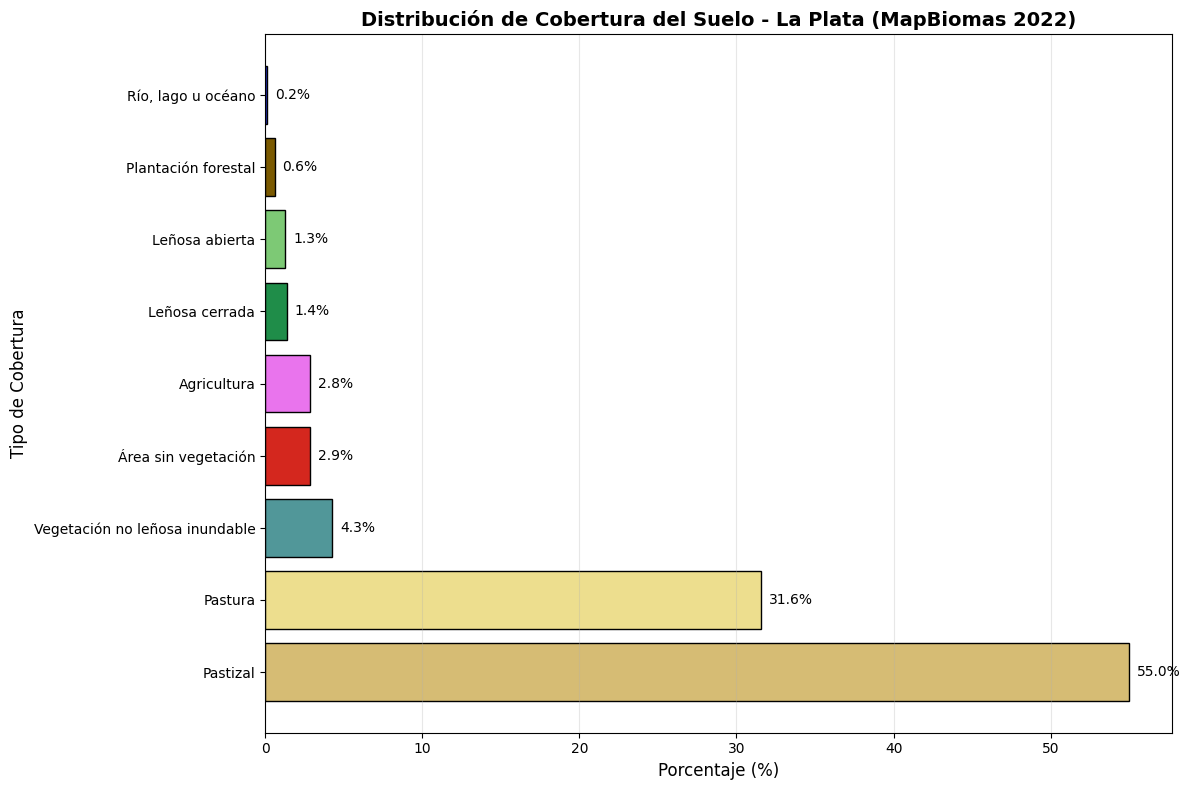

In [69]:
# Crear gráfico de barras horizontal
fig, ax = plt.subplots(figsize=(12, 8))

nombres = [cat[0] for cat in categorias_ordenadas]
porcentajes = [cat[1]["porcentaje"] for cat in categorias_ordenadas]
colores = [cat[1]["color"] for cat in categorias_ordenadas]

barras = ax.barh(nombres, porcentajes, color=colores, edgecolor="black")

ax.set_xlabel("Porcentaje (%)", fontsize=12)
ax.set_ylabel("Tipo de Cobertura", fontsize=12)
ax.set_title(
    "Distribución de Cobertura del Suelo - La Plata (MapBiomas 2022)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(True, alpha=0.3, axis="x")

# Agregar etiquetas de porcentaje en las barras
for barra, pct in zip(barras, porcentajes):
    ax.text(
        pct + 0.5,
        barra.get_y() + barra.get_height() / 2,
        f"{pct:.1f}%",
        va="center",
        fontsize=10,
    )

plt.tight_layout()
plt.show()


Finalmente, hacemos estadísticas zonales para extraer la clase dominante y segunda clase dominante por cuenca.

In [70]:
# Analizar la cobertura del suelo dominante por cuenca usando estadísticas zonales

# Paso 1: Crear mapeo de IDs de píxel a categorías
pixel_a_categoria = {}
for nombre, info in categorias.items():
    for id_pixel in info["ids"]:
        pixel_a_categoria[id_pixel] = nombre

print(f"Mapeo creado para {len(pixel_a_categoria)} IDs de píxel")
print(f"Ejemplo: ID 3 → {pixel_a_categoria.get(3)}")

Mapeo creado para 16 IDs de píxel
Ejemplo: ID 3 → Leñosa cerrada


In [ ]:
# Paso 2: Calcular estadísticas zonales categóricas
# Esto cuenta cuántos píxeles de cada clase hay en cada cuenca
estadisticas_cuencas = zonal_stats(
    cuencas,
    suelo_2022_masked.values[0],
    affine=suelo_2022_masked.rio.transform(),
    categorical=True,  # Contar píxeles por categoría
    nodata=0,  # MapBiomas usa 0 para NoData
)

print(f"\nEstadísticas calculadas para {len(estadisticas_cuencas)} cuencas")
print("\nEjemplo de resultado para la primera cuenca:")
print(f"  IDs presentes: {list(estadisticas_cuencas[0].keys())}")
print(f"  Conteos: {list(estadisticas_cuencas[0].values())}")


Estadísticas calculadas para 10 cuencas

Ejemplo de resultado para la primera cuenca:
  IDs presentes: [3.0, 4.0, 9.0, 11.0, 12.0, 15.0, 18.0, 22.0, 33.0]
  Conteos: [36326, 70874, 24574, 384685, 4473355, 2708555, 223092, 52982, 4363]


In [ ]:
# Paso 4: Identificar cobertura dominante y segunda más común por cuenca
cobertura_dominante = []
cobertura_secundaria = []

for estadisticas in estadisticas_cuencas:
    if estadisticas:
        # Ordenar por conteo de píxeles (mayor a menor)
        clases_ordenadas = sorted(
            estadisticas.items(), key=lambda x: x[1], reverse=True
        )

        # Obtener clase dominante (primera)
        id_dominante = clases_ordenadas[0][0]
        clase_dominante = pixel_a_categoria.get(id_dominante, "Desconocido")
        cobertura_dominante.append(clase_dominante)

        # Obtener segunda clase más común
        if len(clases_ordenadas) > 1:
            id_secundario = clases_ordenadas[1][0]
            clase_secundaria = pixel_a_categoria.get(id_secundario, "Desconocido")
            cobertura_secundaria.append(clase_secundaria)
        else:
            cobertura_secundaria.append("N/A")
    else:
        cobertura_dominante.append("Sin Datos")
        cobertura_secundaria.append("Sin Datos")

print("\nCoberturas identificadas:")
print(f"  Dominantes únicas: {set(cobertura_dominante)}")
print(f"  Secundarias únicas: {set(cobertura_secundaria)}")


Coberturas identificadas:
  Dominantes únicas: {'Pastizal', 'Área sin vegetación'}
  Secundarias únicas: {'Pastizal', 'Pastura', 'Área sin vegetación', 'Leñosa cerrada'}


In [73]:
# Paso 5: Agregar resultados al GeoDataFrame y ordenar por área
cuencas["cobertura_dominante"] = cobertura_dominante
cuencas["cobertura_secundaria"] = cobertura_secundaria
cuencas = cuencas.sort_values("area_m", ascending=False)

print("\nResultados por cuenca (ordenadas por área):")
cuencas[
    [
        "Cuenca",
        "Sistema",
        "Subcuenca",
        "RegiónHí",
        "area_m",
        "cobertura_dominante",
        "cobertura_secundaria",
    ]
]


Resultados por cuenca (ordenadas por área):


,Cuenca,Sistema,Subcuenca,RegiónHí,area_m,cobertura_dominante,cobertura_secundaria
83,Cuenca Río Samborombón,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,5.643661e+09,Pastizal,Pastura
72,Area de Bañados,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,4.471614e+08,Pastizal,Área sin vegetación
54,Cuenca Arroyo El Pescado,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,3.574595e+08,Pastizal,Pastura
38,Cuenca Arroyo Martín-Carnaval,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,8.003825e+07,Pastizal,Pastura
53,Cuenca Arroyo Pereyra,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,6.055430e+07,Pastizal,Leñosa cerrada
34,Cuenca Arroyo del Gato,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,5.267390e+07,Área sin vegetación,Pastizal
35,Cuenca Arroyo del Gato,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,4.267169e+07,Pastizal,Área sin vegetación
129,Cuenca A° Maldonado,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,3.575884e+07,Pastizal,Área sin vegetación
36,Cuenca Arroyo Rodriguez-Don Carlos,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,3.283828e+07,Pastizal,Pastura
32,Cuenca Arroyo Rodriguez-Don Carlos,REGION NORESTE,,Vertiente Río de La Plata y Samborombón,8.862363e+06,Pastizal,Pastura



La próxima semana seguimos con análisis más profundos y operaciones más complejas, incorporando más fuentes de Argentina y globales para profundizar en el análisis de datos geoespaciales aplicados a los riesgos climáticos.